<a href="https://colab.research.google.com/github/ZeroToH3ro/Predictive-Model-Advance/blob/main/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def sequence_to_features(seq, seq_type='dna', daas=None):
    """
    seq_type='dna' will apply the DNA mapping,
    seq_type='aa'  will apply the amino acid mapping.
    daas is 1 if the medicine is used, else 0.
    """
    # DNA base mapping
    base_dict = {
        'A': 1, 'C': 2, 'G': 3, 'T': 4,
        'N': 0, '-': 0,
        'R': 5, 'Y': 6, 'M': 7, 'K': 8,
        'S': 9, 'W': 10, 'H': 11, 'B': 12,
        'V': 13, 'D': 14
    }

    # Amino acid mapping
    aa_dict = {
        'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
        'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
        'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
        'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
        '-': 0, 'X': 0
    }

    features = []
    if seq_type == 'dna':
        features = [base_dict.get(base, 0) for base in seq]
    elif seq_type == 'aa':
        features = [aa_dict.get(aa, 0) for aa in seq]
    else:
        raise ValueError("seq_type must be either 'dna' or 'aa'")

    # Include DAAS (medicine) as a binary feature if provided
    if daas is not None:
        features.append(int(daas))  # 1 if True, else 0

    return features

In [16]:
def prepare_data_nucleotide(data_path):
    # Load dataset
    data = pd.read_excel(data_path)

    # Build feature matrix X using Nucleotide + DAAS
    X_list = []
    for idx, row in data.iterrows():
        nucleotide_seq = str(row['Nucleotide']) if pd.notna(row['Nucleotide']) else ''
        # Convert the DAAS column to 1 if not empty (or if the user took the medicine)
        daas_value = row['DAAS'] if 'DAAS' in data.columns else None

        # Create features
        features = sequence_to_features(
            seq=nucleotide_seq,
            seq_type='dna',
            daas=daas_value
        )
        X_list.append(features)

    # Convert list of lists into a 2D numpy array
    X = np.array(X_list, dtype=float)

    # Target vector y from "Respond"
    # Modified to map specific values, check for potential issues
    # For example, 'Yes'/'No' mapping. Adjust as per your data
    y = data['Respond'].map({'Yes': 1, 'No': 0}).values

    # Add a check for unique values in y:
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                         f"At least two classes are needed for classification.")

    return X, y

In [18]:
def prepare_data_amino(data_path):
    # Load dataset
    data = pd.read_excel(data_path)

    # Build feature matrix X using Amino_Acid + DAAS
    X_list = []
    for idx, row in data.iterrows():
        aa_seq = str(row['Amino_Acid']) if pd.notna(row['Amino_Acid']) else ''
        daas_value = row['DAAS'] if 'DAAS' in data.columns else None

        # Create features
        features = sequence_to_features(
            seq=aa_seq,
            seq_type='aa',
            daas=daas_value
        )
        X_list.append(features)

    X = np.array(X_list, dtype=float)

    # Target vector y from "Respond"
    y = data['Respond'].map({'Yes': 1, 'No': 0}).values # Assume your data has 'Yes' and 'No' values.

    # Add a check for unique values in y:
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                         f"At least two classes are needed for classification.")

    return X, y

In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm

In [31]:
def plot_model_comparison(results):
    """
    Create visualizations comparing model performance
    """
    # Accuracy comparison
    plt.figure(figsize=(12, 6))
    accuracies = {name: res['accuracy'] for name, res in results.items()}
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(12, 6))
    for name, res in results.items():
        if 'roc_curve' in res:
            # Check the length of roc_curve before unpacking
            roc_curve_data = res['roc_curve']
            if len(roc_curve_data) == 3:  # If roc_curve returns 3 values
                fpr, tpr, _ = roc_curve_data
            elif len(roc_curve_data) == 2:  # If roc_curve returns 2 values
                fpr, tpr = roc_curve_data
                # Print a message and assign a value of 0 to AUC to prevent errors
                print(f"Warning: ROC curve for {name} has only 2 values. AUC will be 0.")
                res["auc"] = 0
            else:
                raise ValueError("Unexpected number of values in roc_curve")
            plt.plot(fpr, tpr, label=f'{name} (AUC = {res["auc"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
def optimize_svm(X_train, y_train):
    """
    Optimize SVM hyperparameters using GridSearchCV
    """
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }

    grid_search = GridSearchCV(
        SVC(probability=True, random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [25]:
def train_and_evaluate_models(X, y, label=''):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models with optimized parameters
    models = {
        'SVM': optimize_svm(X_train_scaled, y_train),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        'FDA': LinearDiscriminantAnalysis(),
        'GBM': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    results = {}
    for name, model in models.items():
        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_curve': (fpr, tpr),
            'auc': auc_score
        }

        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(report)

    # Plot comparisons
    plot_model_comparison(results)

    return results


Results for SVM:
Accuracy: 0.8293
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.89      0.91      0.90        35

    accuracy                           0.83        41
   macro avg       0.64      0.62      0.63        41
weighted avg       0.82      0.83      0.82        41


Results for Neural Network:
Accuracy: 0.8049
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.94      0.83      0.88        35

    accuracy                           0.80        41
   macro avg       0.67      0.75      0.69        41
weighted avg       0.86      0.80      0.82        41


Results for KNN:
Accuracy: 0.7805
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.67      0.47         6
           1       0.93      0.80      0.86        3

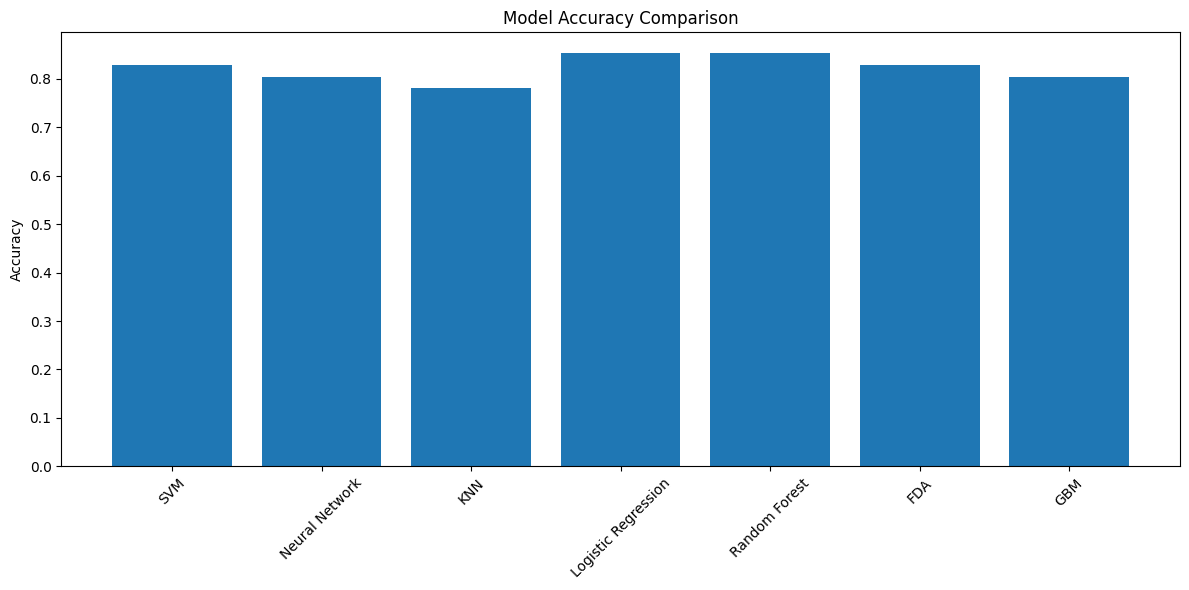

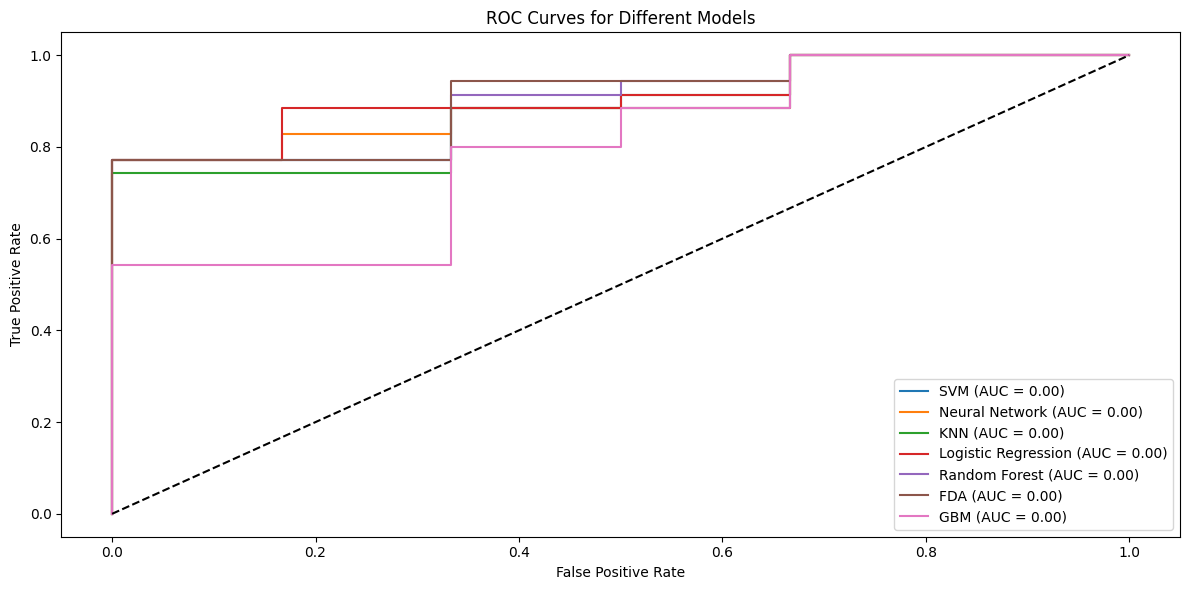


Results for SVM:
Accuracy: 0.9024
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.90      1.00      0.95        35

    accuracy                           0.90        41
   macro avg       0.95      0.67      0.72        41
weighted avg       0.91      0.90      0.88        41


Results for Neural Network:
Accuracy: 0.8537
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.94      0.89      0.91        35

    accuracy                           0.85        41
   macro avg       0.72      0.78      0.74        41
weighted avg       0.88      0.85      0.86        41


Results for KNN:
Accuracy: 0.8049
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         6
           1       0.94      0.83      0.88        3

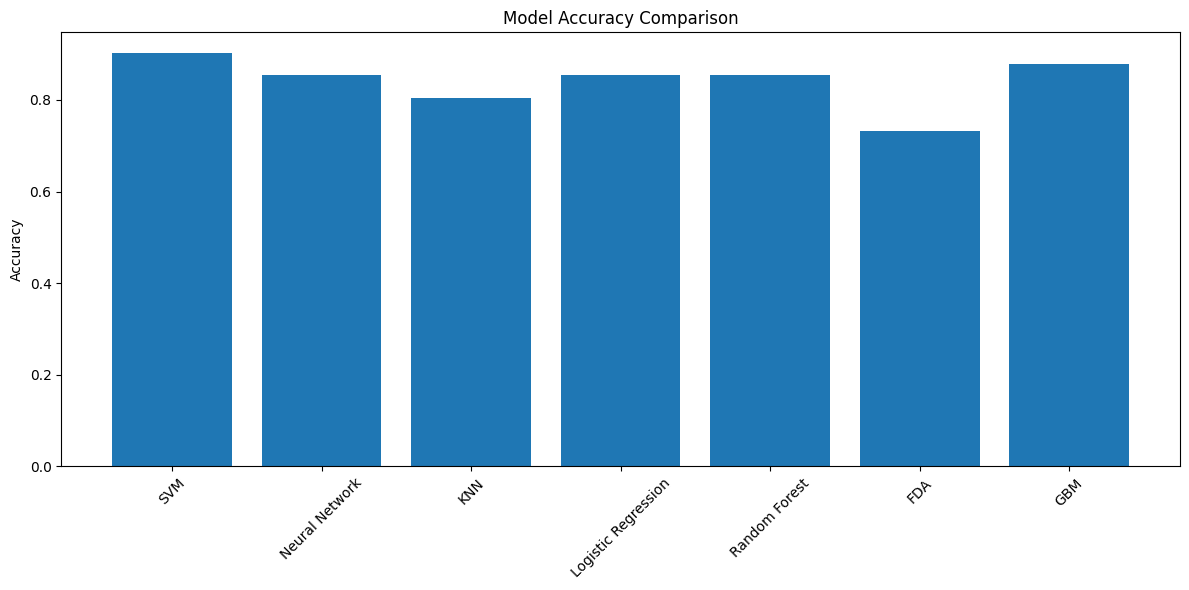

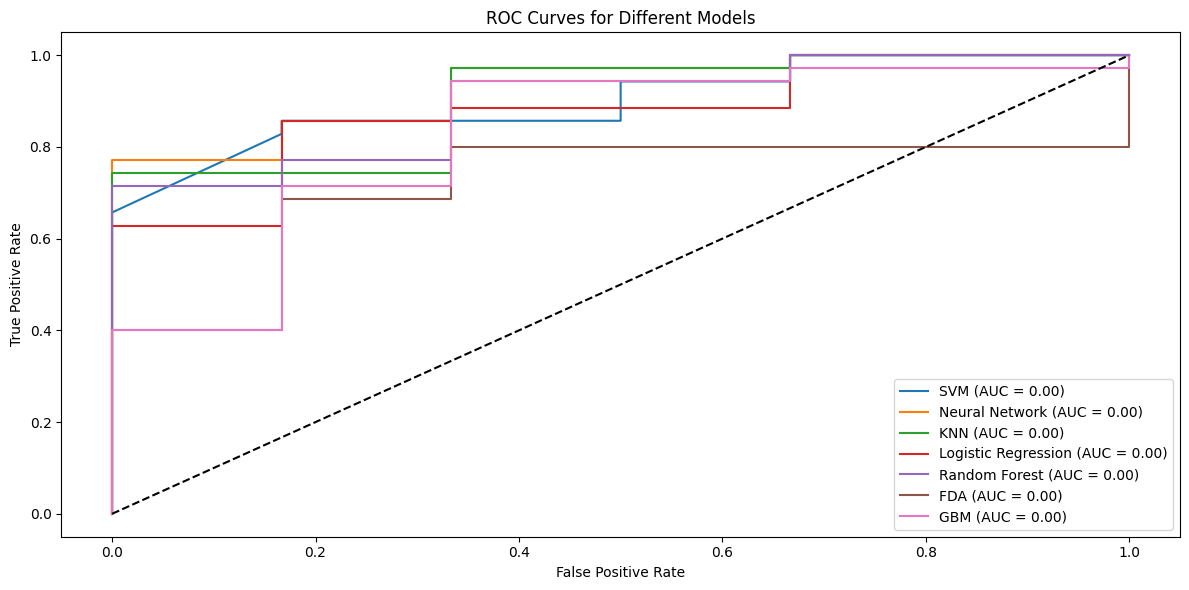

In [32]:
# Path to your actual Excel data
data_path = "sample_data/134-samples-aligned-cutted-Nu-and-a.a-17.12.24.xlsx"

# 1) Prepare Nucleotide-based dataset
X_nu, y_nu = prepare_data_nucleotide(data_path)
results_nu = train_and_evaluate_models(X_nu, y_nu, label='Nucleotide')

# 2) Prepare Amino_Acid-based dataset
X_aa, y_aa = prepare_data_amino(data_path)
results_aa = train_and_evaluate_models(X_aa, y_aa, label='Amino_Acid')